# Satellite Image to Map Image Translation using Pix2Pix GAN




## 1. Importing Libraries

In [60]:
import numpy as np
from numpy import asarray, load, vstack, zeros, ones
from numpy.random import randint
from os import listdir
from matplotlib import pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model,load_model
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate , Input
from keras.layers import Dropout, BatchNormalization
from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.image import ssim
from numpy import savez_compressed
from sklearn.model_selection import train_test_split

In [2]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Loading and Visualizing the Dataset

Dataset Download Link - http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

In [3]:
# Function to load and preprocess images
def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()

    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):

        # load and resize the image
        pixels = load_img(path + filename, target_size=size)

        # convert to numpy array
        pixels = img_to_array(pixels)

        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)

    return [asarray(src_list), asarray(tar_list)]

# Dataset path
path = '/content/drive/MyDrive/maps/train/'
path2 = '/content/drive/MyDrive/maps/val/'

# Load dataset
[src_train, tar_train] = load_images(path)
[src_val, tar_val] = load_images(path2)

# # Combine the datasets
src_images = asarray(list(src_train) + list(src_val))
tar_images = asarray(list(tar_train) + list(tar_val))

# Split into train and test sets (80% train, 20% test)
src_train, src_test, tar_train, tar_test = train_test_split(src_images, tar_images, test_size=0.2, random_state=42)

# Print shapes of the datasets
print('Train dataset: ', src_train.shape, tar_train.shape)
print('Test dataset: ', src_test.shape, tar_test.shape)

# # New way
# [src_images,tar_images] = load_images(path)
# print('Dataset: ', src_images.shape, tar_images.shape)


Train dataset:  (1755, 256, 256, 3) (1755, 256, 256, 3)
Test dataset:  (439, 256, 256, 3) (439, 256, 256, 3)


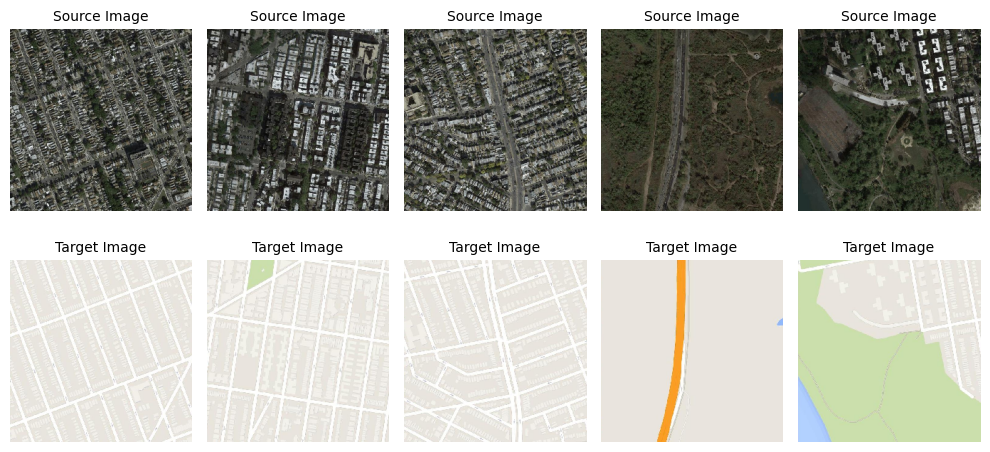

In [4]:
# Number of samples to visualize
n_samples = 5

plt.figure(figsize=(10, 5))

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.title('Source Image', fontsize=10)
    plt.axis('off')
    plt.imshow(src_train[i].astype('uint8'))

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.title('Target Image', fontsize=10)
    plt.axis('off')
    plt.imshow(tar_train[i].astype('uint8'))

plt.tight_layout()
plt.show()


## 3. Preprocessing the Dataset

In [5]:
# Converting the Scale of Images

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]

	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

data_train = [src_train, tar_train]
data_test = [src_test, tar_test]

dataset_train = preprocess_data(data_train)
dataset_test = preprocess_data(data_test)

# dataset = [src_images, tar_images]
# dataset = preprocess_data(dataset)

## 4. Defining the Pix2Pix GAN Model
Since pix2pix is a conditional GAN, it takes 2 inputs - image and corresponding label.

### Generator
Defining the Generator - in our case we will define a U-net

In [6]:
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):

	  # weight initialization
	  init = RandomNormal(stddev=0.02)

	  # add downsampling layer
	  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	  # conditionally add batch normalization
	  if batchnorm:
	  	g = BatchNormalization()(g, training=True)

	  # leaky relu activation
	  g = LeakyReLU(alpha=0.2)(g)

	  return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):

    # weight initialization
	  init = RandomNormal(stddev=0.02)

	  # add upsampling layer
	  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	  # add batch normalization
	  g = BatchNormalization()(g, training=True)

	  # conditionally add dropout
	  if dropout:
	  	g = Dropout(0.5)(g, training=True)

	  # merge with skip connection
	  g = Concatenate()([g, skip_in])

	  # relu activation
	  g = Activation('relu')(g)
	  return g

In [44]:
# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
	  # weight initialization
	  init = RandomNormal(stddev=0.02,seed=42)

	  # image input
	  in_image = Input(shape=image_shape)

	  # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	  e1 = define_encoder_block(in_image, 64, batchnorm=False)
	  e2 = define_encoder_block(e1, 128)
	  e3 = define_encoder_block(e2, 256)
	  e4 = define_encoder_block(e3, 512)
	  e5 = define_encoder_block(e4, 512)
	  e6 = define_encoder_block(e5, 512)
	  e7 = define_encoder_block(e6, 512)
	  # bottleneck, no batch norm and relu

	  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	  b = Activation('relu')(b)

	  # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	  d1 = decoder_block(b, e7, 512)
	  d2 = decoder_block(d1, e6, 512)
	  d3 = decoder_block(d2, e5, 512)
	  d4 = decoder_block(d3, e4, 512, dropout=False)
	  d5 = decoder_block(d4, e3, 256, dropout=False)
	  d6 = decoder_block(d5, e2, 128, dropout=False)
	  d7 = decoder_block(d6, e1, 64, dropout=False)

	  # output
	  g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	  out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	  # define model
	  model = Model(in_image, out_image)
	  return model

In [8]:
# gen_model = define_generator((256,256,3))


### Discriminator
Given an input image, the Discriminator outputs the likelihood of the image being real.<br>
Binary classification - true or false (1 or 0). So using sigmoid activation.

In [45]:
# Structure - C64-C128-C256-C512. After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.

# PatchGAN , which doesn't classify the entire image as real or fake but instead focuses on classifying patches of the image as real or fake.
def define_discriminator(image_shape):

	  # weight initialization
	  init = RandomNormal(stddev=0.02,seed=42)

	  # source image input
	  in_src_image = Input(shape=image_shape)  #Image we want to convert to another image

	  # target image input
	  in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

	  # concatenate images, channel-wise
	  merged = Concatenate()([in_src_image, in_target_image])

	  # C64: 4x4 kernel Stride 2x2
	  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	  d = LeakyReLU(alpha=0.2)(d)

	  # C128: 4x4 kernel Stride 2x2
	  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	  d = BatchNormalization()(d)
	  d = LeakyReLU(alpha=0.2)(d)

	  # C256: 4x4 kernel Stride 2x2
	  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	  d = BatchNormalization()(d)
	  d = LeakyReLU(alpha=0.2)(d)

	  # C512: 4x4 kernel Stride 2x2
	  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	  d = BatchNormalization()(d)
	  d = LeakyReLU(alpha=0.2)(d)
	  # second last output layer : 4x4 kernel but Stride 1x1
	  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	  d = BatchNormalization()(d)
	  d = LeakyReLU(alpha=0.2)(d)

	  # patch output
	  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	  patch_out = Activation('sigmoid')(d)
	  # define model
	  model = Model([in_src_image, in_target_image], patch_out)

	  # compile model
    # The model is trained with a batch size of one image, and Adam opts.
    # with a small learning rate and 0.5 beta.
    # The loss for the discriminator is weighted by 50% for each model update.

	  opt = Adam(learning_rate=0.0002, beta_1=0.5)
	  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=0.5)

	  return model

### GAN - Combined Generator and Descriminator

In [46]:
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False  # Discriminator layers set to untrainable in the combined GAN

    # define the source image
    in_src = Input(shape=image_shape)

    # supply the image as input to the generator
    gen_out = g_model(in_src)

    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])

    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])

    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    # Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    # Weighting BCE vs L1 (mae) as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])

    return model


In [53]:
!sudo apt install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [65]:
!pip install pydot

In [68]:
# define input shape based on the loaded dataset
image_shape = src_train.shape[1:]
# print(image_shape)

# defining the Generator the model
g_model = define_generator(image_shape)
# plot_model(g_model, to_file='gen_model.png', show_shapes=True)

In [69]:
# Defining the Discriminator Model

d_model = define_discriminator(image_shape)
# plot_model(d_model, to_file='disc_model.png', show_shapes=True)

In [70]:
# Defining the Composite GAN model

gan_model = define_gan(g_model, d_model, image_shape)
# plot_model(gan_model, to_file='gan_model.png', show_shapes=True)

## 5. Function for Generating Real and Fake Samples for our GAN Model

In [14]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	  # unpack dataset
	  trainA, trainB = dataset

	  # choose random instances
	  ix = randint(0, trainA.shape[0], n_samples)

	  # retrieve selected images
	  X1, X2 = trainA[ix], trainB[ix]

	  # generate 'real' class labels (1)
	  y = ones((n_samples, patch_shape, patch_shape, 1))
	  return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):

	  # generate fake instance
	  X = g_model.predict(samples)

	  # create 'fake' class labels (0)
	  y = zeros((len(X), patch_shape, patch_shape, 1))
	  return X, y

## 6. Training and Evaluating our Pix2Pix GAN Model

In [15]:
# Generate samples and save as a plot and save the model
# GAN models do not converge, we just want to find a good balance between
# the generator and the discriminator. Therefore, it makes sense to periodically
# save the generator model and check how good the generated image looks.

def Save_model_summarize_performance(epoch, g_model, dataset, n_samples=5):
    # Select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)

    # Generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    # Scale all pixels from [-1, 1] to [0, 1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # Plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.title('Source Image', fontsize=10)
        plt.axis('off')
        plt.imshow(X_realA[i])

    # Plot generated target images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.title('Generated Image', fontsize=10)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    # Plot real target images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.title('Target Image', fontsize=10)
        plt.axis('off')
        plt.imshow(X_realB[i])

    plt.subplots_adjust(wspace=0.3)

    # Save plot to file
    filename1 = '/content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_%03d.png' % (epoch + 1)
    plt.savefig(filename1)
    plt.close()
    print('>Saved generated image at %d epoch as %s '% (epoch+1,filename1))

    # Save the generator model
    filename2 = '/content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_%03d.h5' % (epoch + 1)
    g_model.save(filename2)
    print('>Saved Generator image at %d epoch as %s '% (epoch+1,filename2))

def calculate_batch_ssim(real_images, generated_images):

    # Ensure images are in the range [0, 1] using NumPy
    real_images = np.clip(real_images, 0.0, 1.0)
    generated_images = np.clip(generated_images, 0.0, 1.0)

    ssim_values = []

    # Loop over images in the batch
    for real, generated in zip(real_images, generated_images):
        # Calculate SSIM
        ssim_value = ssim(real, generated, max_val=1.0)
        ssim_values.append(K.eval(ssim_value))  # Convert from Tensor to numpy value

    # Average SSIM over the batch
    avg_ssim = np.mean(ssim_values)

    return avg_ssim


### Summarizing Model Performance with Plotting and Saving

### Training the Pix2Pix GAN Model

In [21]:
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
    # Determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    # Unpack dataset
    trainA, trainB = dataset

    # Calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)

    # Initialize the best SSIM (higher is better)
    best_ssim = -float('inf')

    # Loop over epochs
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')
        batches_ssim = []

        for i in range(bat_per_epo):
            # Select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

            # Generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            # Update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

            # Update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            # Update the generator
            g_loss, d_out, gen_out = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            # Calculate SSIM for this batch
            batch_ssim = calculate_batch_ssim(X_realB, X_fakeB)
            batches_ssim.append(batch_ssim)

            # Print batch progress
            print(f'Batch {i+1}/{bat_per_epo}, d1[{d_loss1:.3f}] d2[{d_loss2:.3f}] g[{g_loss:.3f}] Batch SSIM[{batch_ssim:.4f}]')

        # Average SSIM over all batches in this epoch
        epoch_ssim = np.mean(batches_ssim)
        print(f'Epoch {epoch+1} Average SSIM: {epoch_ssim:.4f}')

        # Summarize and Saving the Model after every 2 epochs
        if( (epoch+1) % 2 == 0):
          Save_model_summarize_performance(epoch, g_model, dataset)

        print()

    print("Training complete.")

In [22]:
from datetime import datetime

start1 = datetime.now()

train(d_model, g_model, gan_model, dataset_train, n_epochs=10, n_batch=10)

#For 10 epochs we should see
stop1 = datetime.now()

#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Epoch 1/10
1/1 [==============================] - 1s 568ms/step
Batch 1/175, d1[0.496] d2[0.524] g[71.489] Batch SSIM[0.0130]
1/1 [==============================] - 1s 577ms/step
Batch 2/175, d1[0.540] d2[0.438] g[67.322] Batch SSIM[0.0153]
1/1 [==============================] - 1s 595ms/step
Batch 3/175, d1[0.441] d2[0.423] g[67.455] Batch SSIM[0.0142]
1/1 [==============================] - 1s 577ms/step
Batch 4/175, d1[0.351] d2[0.396] g[65.124] Batch SSIM[0.0155]
1/1 [==============================] - 1s 559ms/step
Batch 5/175, d1[0.286] d2[0.372] g[62.860] Batch SSIM[0.0172]
1/1 [==============================] - 1s 573ms/step
Batch 6/175, d1[0.251] d2[0.332] g[58.143] Batch SSIM[0.0203]
1/1 [==============================] - 1s 562ms/step
Batch 7/175, d1[0.196] d2[0.296] g[59.191] Batch SSIM[0.0178]
1/1 [==============================] - 1s 567ms/step
Batch 8/175, d1[0.170] d2[0.258] g[52.368] Batch SSIM[0.0235]
1/1 [==============================] - 1s 562ms/step
Batch 9/175, d1[

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved generated image at 2 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_002.png 
>Saved Generator image at 2 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_002.h5 

Epoch 3/10
1/1 [==============================] - 1s 532ms/step
Batch 1/175, d1[0.125] d2[0.090] g[12.266] Batch SSIM[0.4246]
1/1 [==============================] - 0s 472ms/step
Batch 2/175, d1[0.589] d2[0.832] g[10.757] Batch SSIM[0.3386]
1/1 [==============================] - 1s 592ms/step
Batch 3/175, d1[0.280] d2[0.369] g[11.087] Batch SSIM[0.3699]
1/1 [==============================] - 0s 492ms/step
Batch 4/175, d1[0.553] d2[0.136] g[10.984] Batch SSIM[0.3864]
1/1 [==============================] - 0s 498ms/step
Batch 5/175, d1[0.416] d2[0.392] g[10.915] Batch SSIM[0.3785]
1/1 [==============================] - 1s 581ms/step
Batch 6/175, d1[0.129] d2[0.499] g[11.291] Batch SSIM[0.3160]
1/1 [==============================] - 1s 526ms/step
Bat

>Saved generated image at 4 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_004.png 
>Saved Generator image at 4 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_004.h5 

Epoch 5/10
1/1 [==============================] - 0s 458ms/step
Batch 1/175, d1[0.222] d2[0.196] g[14.861] Batch SSIM[0.2841]
1/1 [==============================] - 1s 536ms/step
Batch 2/175, d1[0.347] d2[0.360] g[12.281] Batch SSIM[0.2922]
1/1 [==============================] - 0s 484ms/step
Batch 3/175, d1[0.058] d2[0.097] g[12.100] Batch SSIM[0.3245]
1/1 [==============================] - 1s 510ms/step
Batch 4/175, d1[0.302] d2[0.254] g[11.119] Batch SSIM[0.3470]
1/1 [==============================] - 1s 534ms/step
Batch 5/175, d1[0.061] d2[0.228] g[11.125] Batch SSIM[0.3721]
1/1 [==============================] - 1s 520ms/step
Batch 6/175, d1[0.824] d2[0.248] g[9.798] Batch SSIM[0.3778]
1/1 [==============================] - 0s 470ms/step
Batc

>Saved generated image at 6 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_006.png 
>Saved Generator image at 6 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_006.h5 

Epoch 7/10
1/1 [==============================] - 1s 520ms/step
Batch 1/175, d1[0.143] d2[0.171] g[9.694] Batch SSIM[0.4504]
1/1 [==============================] - 0s 453ms/step
Batch 2/175, d1[0.026] d2[0.078] g[11.570] Batch SSIM[0.3888]
1/1 [==============================] - 1s 526ms/step
Batch 3/175, d1[0.040] d2[0.050] g[11.061] Batch SSIM[0.4489]
1/1 [==============================] - 1s 560ms/step
Batch 4/175, d1[0.047] d2[0.035] g[11.580] Batch SSIM[0.4134]
1/1 [==============================] - 0s 477ms/step
Batch 5/175, d1[0.023] d2[0.061] g[10.569] Batch SSIM[0.4311]
1/1 [==============================] - 0s 473ms/step
Batch 6/175, d1[0.017] d2[0.126] g[10.831] Batch SSIM[0.4914]
1/1 [==============================] - 1s 535ms/step
Batc

>Saved generated image at 8 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_008.png 
>Saved Generator image at 8 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_008.h5 

Epoch 9/10
1/1 [==============================] - 1s 512ms/step
Batch 1/175, d1[0.999] d2[0.634] g[10.310] Batch SSIM[0.4687]
1/1 [==============================] - 0s 483ms/step
Batch 2/175, d1[0.276] d2[0.113] g[9.233] Batch SSIM[0.4793]
1/1 [==============================] - 0s 459ms/step
Batch 3/175, d1[0.130] d2[0.334] g[12.018] Batch SSIM[0.3605]
1/1 [==============================] - 1s 522ms/step
Batch 4/175, d1[0.407] d2[0.266] g[9.930] Batch SSIM[0.4075]
1/1 [==============================] - 0s 486ms/step
Batch 5/175, d1[0.126] d2[0.096] g[9.907] Batch SSIM[0.4355]
1/1 [==============================] - 1s 557ms/step
Batch 6/175, d1[0.047] d2[0.248] g[10.486] Batch SSIM[0.4217]
1/1 [==============================] - 1s 518ms/step
Batch 

>Saved generated image at 10 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_010.png 
>Saved Generator image at 10 epoch as /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_010.h5 

Training complete.
Execution time is:  1:30:22.821441


### 7. Evauating on Test dataset

1/1 [==============================] - 1s 671ms/step


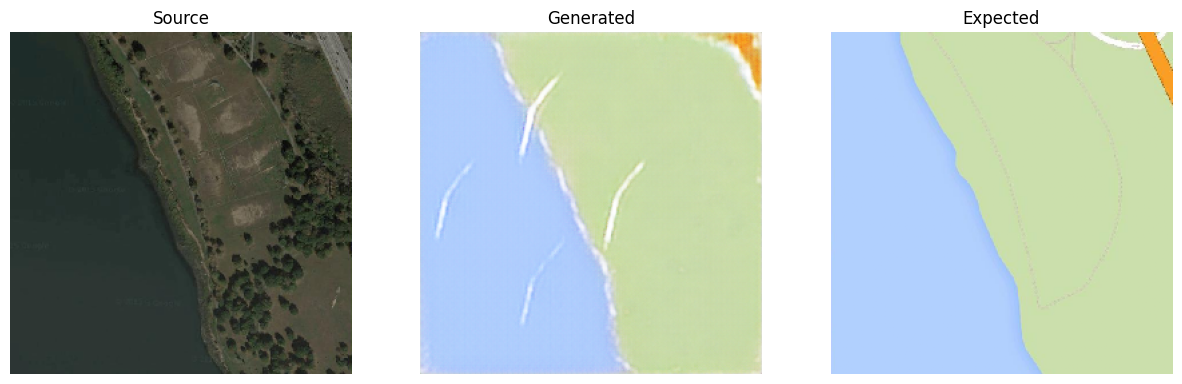

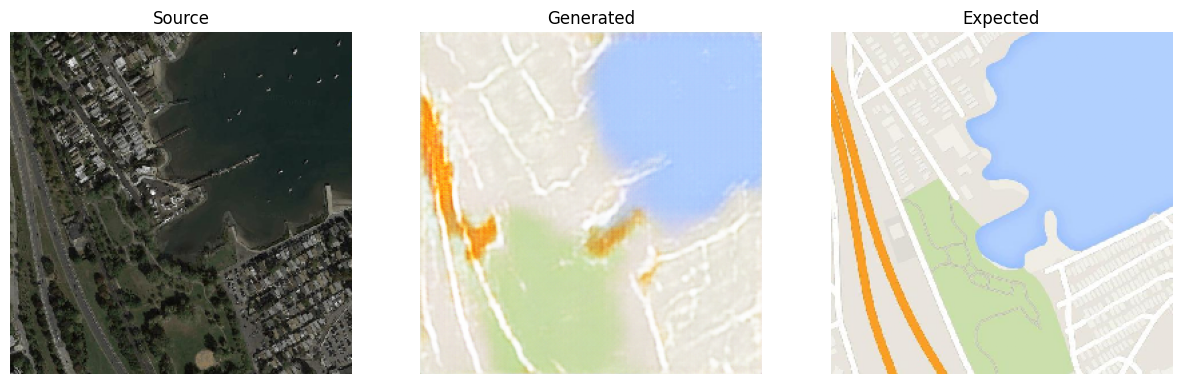

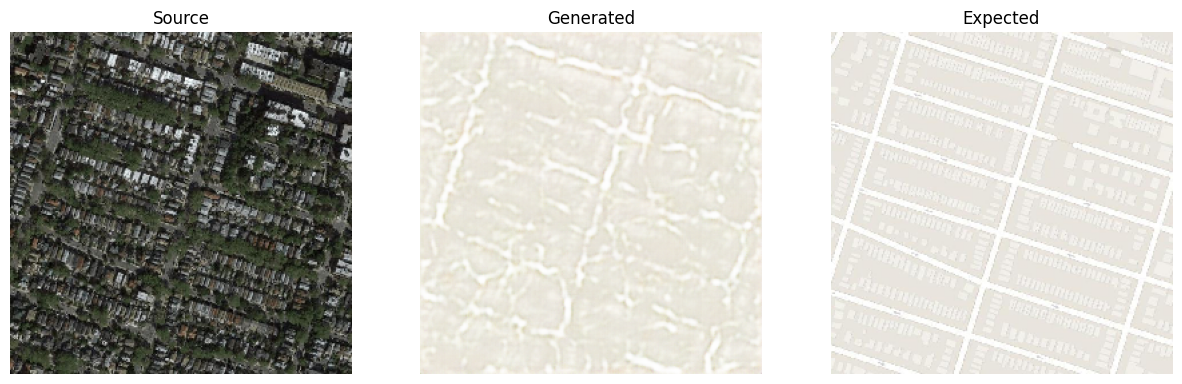

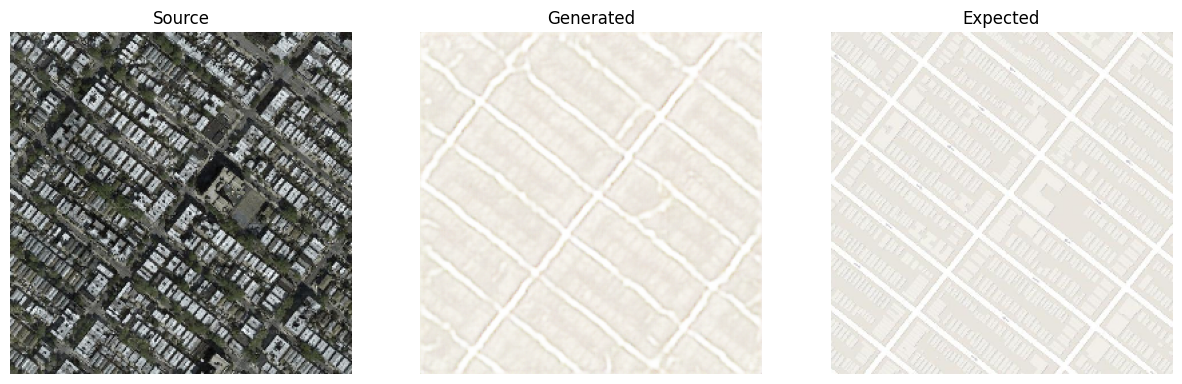

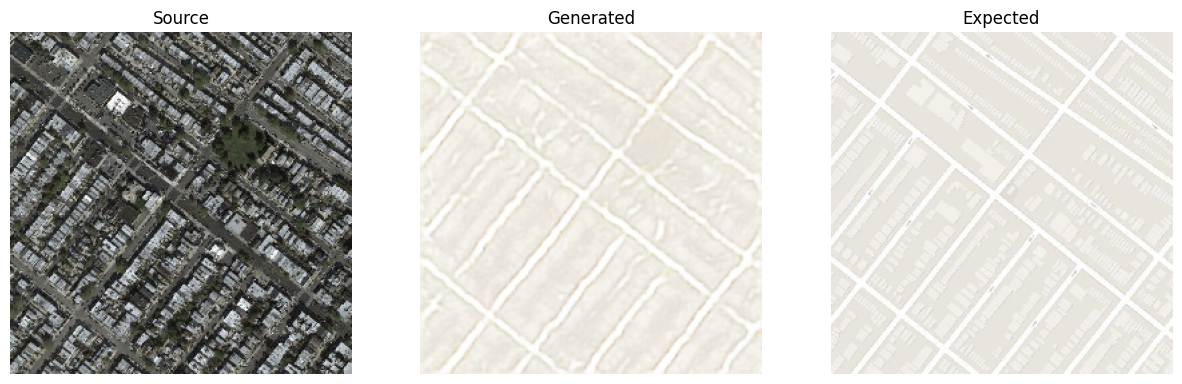

In [34]:
# Load the pre-trained model
model = load_model('/content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_010.h5')

# Plot source, generated, and target images for multiple samples
def plot_images(src_imgs, gen_imgs, tar_imgs, n_samples):
    # Scale from [-1, 1] to [0, 1]
    src_imgs = (src_imgs + 1) / 2.0
    gen_imgs = (gen_imgs + 1) / 2.0
    tar_imgs = (tar_imgs + 1) / 2.0

    for i in range(n_samples):
        # Create a new figure for each sample
        plt.figure(figsize=(15, 5))  # Adjust the figsize as needed

        # Plot source image
        plt.subplot(1, 3, 1)
        plt.imshow(src_imgs[i])
        plt.axis('off')
        plt.title('Source')

        # Plot generated image
        plt.subplot(1, 3, 2)
        plt.imshow(gen_imgs[i])
        plt.axis('off')
        plt.title('Generated')

        # Plot target image
        plt.subplot(1, 3, 3)
        plt.imshow(tar_imgs[i])
        plt.axis('off')
        plt.title('Expected')

        # Show the plot for the current sample
        plt.show()

# Load validation dataset (assumed to be pre-loaded as dataset_val)
[X1, X2] = dataset_test

# Number of samples to generate and plot
n_samples = 5

# Select random examples
indices = randint(0, len(X1), n_samples)
src_images, tar_images = X1[indices], X2[indices]

# Generate images from source
gen_images = model.predict(src_images)

# Plot all images
plot_images(src_images, gen_images, tar_images, n_samples)

In [37]:
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 782.5 kB/s eta 0:00:00
